In [3]:
# import packages
from scripts.functions import *
from PIL import Image
import numpy as np
from keras.datasets import cifar10
from PIL import Image
import imageio
import os
from sklearn.preprocessing import LabelEncoder
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2

In [ ]:
import tensorflow
from tensorflow.python.client import device_lib
tensorflow.config.list_physical_devices('GPU')

Local Approximation

In [ ]:
name = 'cifar'
#-------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------- 1. Initial settings. -------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------#

resize_shape = (96,96)  # Resized image's shape
sigma = 6                # Noise standard deviation

window_shape = (8,8)     # Patches' shape
step = 4                  # Patches' step
ratio = 1                 # Ratio for the dictionary (training set)
ksvd_iter = 5             # Number of iterations for the K-SVD
omp = "single"            # Choose the type of orthogonal projection

# Define directories for each image type
original_dir = 'original_images'
noisy_dir = 'noisy_images'
denoise_dir = 'denoised_images'

# Create directories if they don't exist
os.makedirs(original_dir, exist_ok=True)
os.makedirs(noisy_dir, exist_ok=True)
os.makedirs(denoise_dir, exist_ok=True)

#-------------------------------------------------------------------------------------------------------------------#
#--------------------------------------------------- 2. Load Images from Directory. ----------------------------#
#-------------------------------------------------------------------------------------------------------------------#

# Directory containing your images
dataset_dir = 'Input'  # Update this to the correct path

# List all image files in the directory
image_files = [f for f in os.listdir(dataset_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]

# Load the images into a list and resize them
train_images = []
for image_file in image_files:
    img_path = os.path.join(dataset_dir, image_file)
    img = Image.open(img_path).convert('L')  # Open and ensure image is in RGB mode
    img_resized = img.resize(resize_shape)    # Resize to (32, 32)
    train_images.append(np.array(img_resized))

train_images = np.array(train_images)

#-------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------- 3. Add noise to images. ---------------------------------------#
#-------------------------------------------------------------------------------------------------------------------#

noisy_images = []
for img in train_images:
    noise_layer = np.random.normal(0, sigma ** 2, img.shape).astype(int)
    noisy_image = img + noise_layer
    noisy_images.append(noisy_image)

noisy_images = np.array(noisy_images)

# Save original and noisy images to respective directories
for i in range(len(noisy_images)):
    imageio.imwrite(os.path.join(original_dir, f'original_image_{i}.jpg'), Image.fromarray(np.uint8(train_images[i])).convert('RGB'))
    imageio.imwrite(os.path.join(noisy_dir, f'noisy_image_{i}.jpg'), Image.fromarray(np.uint8(noisy_images[i])).convert('RGB'))

#-------------------------------------------------------------------------------------------------------------------#
#----------------------------------------------------- 4. Denoising. ---------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------#

denoised_images = []
for noisy_image, train_image in zip(noisy_images, train_images):
    denoised_image, calc_time, n_total = denoising(noisy_image, train_image, window_shape, step, sigma, ratio, ksvd_iter, omp = omp)
    denoised_images.append(denoised_image)

denoised_images = np.array(denoised_images)

# Initialize accumulators for PSNR and MSE
total_psnr_original_denoised = 0
total_psnr_original_noisy = 0
total_mse_original_denoised = 0
total_mse_original_noisy = 0

# Calculate PSNR and MSE for each image, print results, and accumulate values for averages
for i in range(len(denoised_images)):
    psnr_original = psnr(train_images[i], denoised_images[i])  # PSNR between original and denoised
    psnr_noisy = psnr(train_images[i], noisy_images[i])        # PSNR between original and noisy
    mse_original = MSE(train_images[i], denoised_images[i])  # MSE between original and denoised
    mse_noisy = MSE(train_images[i], noisy_images[i])        # MSE between original and noisy

    # Print individual PSNR and MSE
    print(f'Image {i + 1} PSNR: Original vs Denoised: {psnr_original:.2f} dB, Original vs Noisy: {psnr_noisy:.2f} dB')
    print(f'Image {i + 1} MSE: Original vs Denoised: {mse_original:.2f}, Original vs Noisy: {mse_noisy:.2f}')

    # Save denoised images
    imageio.imwrite(os.path.join(denoise_dir, f'denoised_image_{i}.jpg'), Image.fromarray(np.uint8(denoised_images[i])).convert('RGB'))

    # Accumulate for averages
    total_psnr_original_denoised += psnr_original
    total_psnr_original_noisy += psnr_noisy
    total_mse_original_denoised += mse_original
    total_mse_original_noisy += mse_noisy

# Calculate and print average PSNR and MSE
average_psnr_original_denoised = total_psnr_original_denoised / len(denoised_images)
average_psnr_original_noisy = total_psnr_original_noisy / len(denoised_images)
average_mse_original_denoised = total_mse_original_denoised / len(denoised_images)
average_mse_original_noisy = total_mse_original_noisy / len(denoised_images)

print("\nAverage Results:")
print(f'Average PSNR (Original vs Denoised): {average_psnr_original_denoised:.2f} dB')
print(f'Average PSNR (Original vs Noisy): {average_psnr_original_noisy:.2f} dB')
print(f'Average MSE (Original vs Denoised): {average_mse_original_denoised:.2f}')
print(f'Average MSE (Original vs Noisy): {average_mse_original_noisy:.2f}')

# Save parameters
with open(f'{name}_Parameters.txt', 'a') as txt:
    txt.write('INITIAL SETTINGS\n----------------' +
              '\n\nResizing shape : ' + str(resize_shape) +
              '\nWindow shape   : ' + str(window_shape) +
              '\nWindow step    : ' + str(step) +
              '\nSigma          : ' + str(sigma) +
              '\nLearning ratio : ' + str(ratio) +
              '\nK-SVD iter.    : ' + str(ksvd_iter) + '\n')



K-SVD, with residual criterion.
-------------------------------
Stage 1/5...
- Sparse coding : Channel 1

d:\Foundation of data Science\Project\kSVD\scripts\functions.py:213: FutureWarning: skimage.util.pad is deprecated and will be removed in version 0.19. Please use numpy.pad instead.
  padded_noisy_image = pad(noisy_image, pad_width=window_shape, mode='symmetric')
d:\Foundation of data Science\Project\kSVD\scripts\functions.py:215: FutureWarning: skimage.util.pad is deprecated and will be removed in version 0.19. Please use numpy.pad instead.
  padded_lea_image = pad(learning_image, pad_width=window_shape, mode='symmetric')


- Dictionary updating complete.

Stage 2/5...
- Dictionary updating complete.

Stage 3/5...
- Dictionary updating complete.

Stage 4/5...
- Dictionary updating complete.

Stage 5/5...
- Dictionary updating complete.

Calculation time : 608.4892447 seconds.

K-SVD, with residual criterion.
-------------------------------
Stage 1/5...
- Dictionary updating complete.

Stage 2/5...
- Dictionary updating complete.

Stage 3/5...
- Dictionary updating complete.

Stage 4/5...
- Dictionary updating complete.

Stage 5/5...
- Dictionary updating complete.

Calculation time : 435.34604820000015 seconds.

K-SVD, with residual criterion.
-------------------------------
Stage 1/5...
- Dictionary updating complete.

Stage 2/5...
- Dictionary updating complete.

Stage 3/5...
- Dictionary updating complete.

Stage 4/5...
- Dictionary updating complete.

Stage 5/5...
- Dictionary updating complete.

Calculation time : 218.03001700000004 seconds.

K-SVD, with residual criterion.
--------------------------

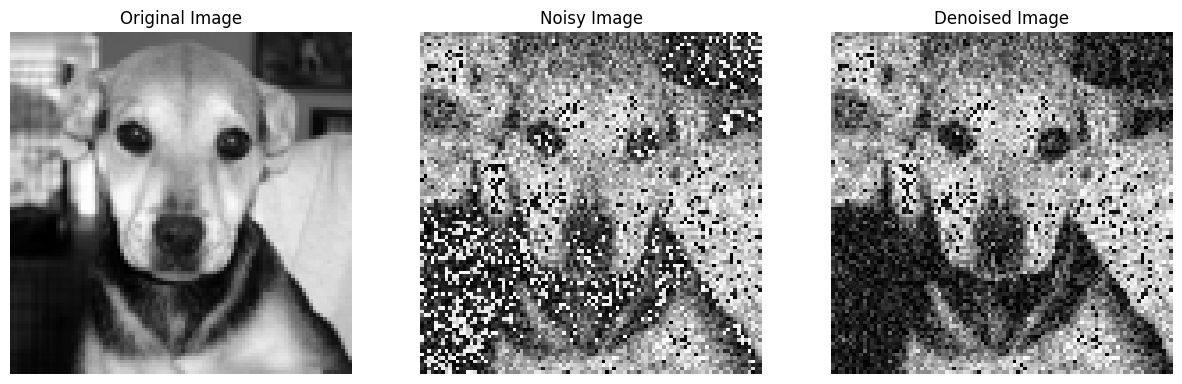

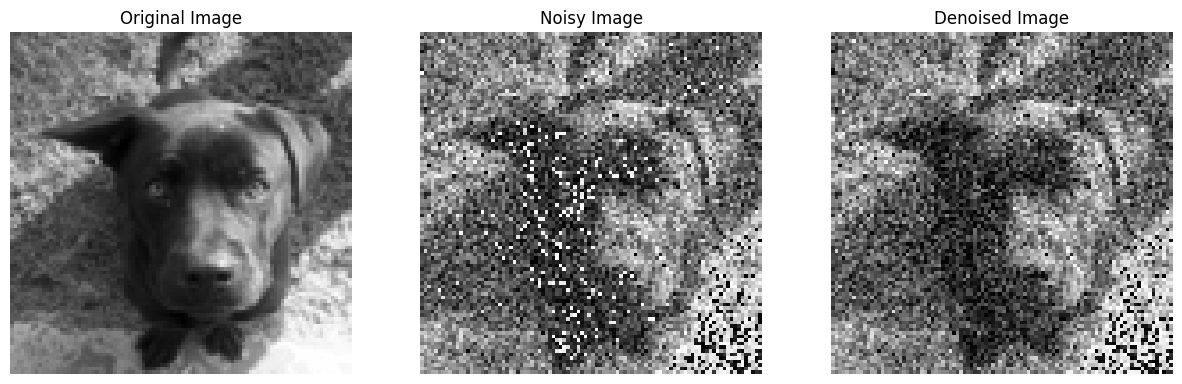

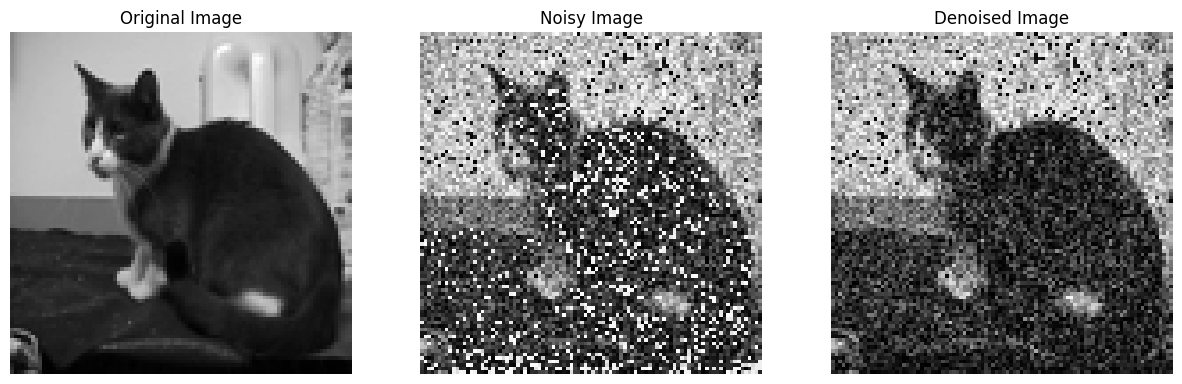

In [ ]:
# Number of samples to display
num_samples = 3

# Select the first few images for visualization
for i in range(min(num_samples, len(train_images))):
    # Create a figure with 3 subplots: Original, Noisy, and Denoised
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(np.uint8(train_images[i]), cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(np.uint8(noisy_images[i]), cmap='gray')
    axes[1].set_title('Noisy Image')
    axes[1].axis('off')

    axes[2].imshow(np.uint8(denoised_images[i]), cmap='gray')
    axes[2].set_title('Denoised Image')
    axes[2].axis('off')

    plt.show()


Global Approximation

/scratch/local/ipykernel_16612/4274001805.py:28: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_noisy = psnr(original, noisy)
/scratch/local/ipykernel_16612/4274001805.py:31: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_denoised = psnr(original, denoised)
/scratch/local/ipykernel_16612/4274001805.py:28: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_noisy = psnr(original, noisy)
/scratch/local/ipykernel_16612/4274001805.py:31: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_denoised = psnr(original, denoised)
/scratch/local/ipykernel_16612/4274001805.py:28: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_noisy = psnr(original, noisy)
/scratch/local/ipykernel_16612/4274001805.py:31: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_denoised = psnr(

Average PSNR (original vs noisy): 12.71 dB
Average MSE (original vs noisy): 3487.48
Average PSNR (original vs denoised): 16.63 dB
Average MSE (original vs denoised): 1421.34


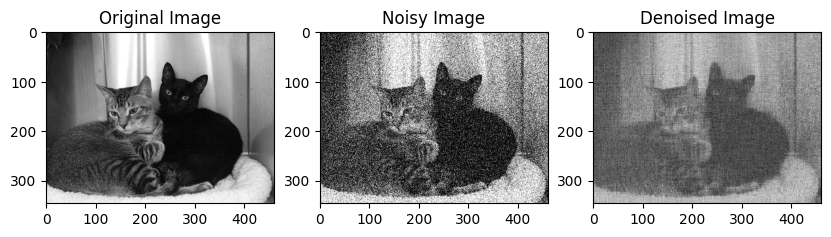

In [ ]:
import os
import numpy as np
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

# Helper function to add Gaussian noise
def add_noise(image, noise_factor=70):
    noisy_image = image + noise_factor * np.random.randn(*image.shape)
    noisy_image = np.clip(noisy_image, 0, 255)  # Clip values to be valid pixel values
    return noisy_image

# Function to apply SVD denoising
def svd_denoise(image, k=50):
    # Perform SVD decomposition
    U, S, Vt = np.linalg.svd(image, full_matrices=False)
    
    # Keep only the top k singular values
    S[k:] = 0  # Set all singular values after the k-th to 0
    
    # Reconstruct the image using the truncated singular values
    denoised_image = np.dot(U, np.dot(np.diag(S), Vt))
    return denoised_image

# Calculate PSNR and MSE
def calculate_metrics(original, noisy, denoised):
    psnr_noisy = psnr(original, noisy)
    mse_noisy = mse(original, noisy)
    
    psnr_denoised = psnr(original, denoised)
    mse_denoised = mse(original, denoised)
    
    return psnr_noisy, mse_noisy, psnr_denoised, mse_denoised

# Create output directory if it doesn't exist
output_dir = 'output_images'  # Update this path if needed
os.makedirs(output_dir, exist_ok=True)

# Load images from folder
image_folder = 'Input'  # Update with your folder path
image_filenames = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]
psnr_noisy_all = []
mse_noisy_all = []
psnr_denoised_all = []
mse_denoised_all = []

# Process each image
for filename in image_filenames:
    image = cv2.imread(os.path.join(image_folder, filename), cv2.IMREAD_GRAYSCALE)
    
    # Add noise
    noisy_image = add_noise(image)
    
    # Denoise with SVD
    denoised_image = svd_denoise(noisy_image)
    
    # Calculate PSNR and MSE
    psnr_noisy, mse_noisy, psnr_denoised, mse_denoised = calculate_metrics(image, noisy_image, denoised_image)
    
    # Store results
    psnr_noisy_all.append(psnr_noisy)
    mse_noisy_all.append(mse_noisy)
    psnr_denoised_all.append(psnr_denoised)
    mse_denoised_all.append(mse_denoised)

    # Save images in the output folder
    base_filename = os.path.splitext(filename)[0]  # Remove extension from original filename
    cv2.imwrite(os.path.join(output_dir, f'{base_filename}_original.png'), image)
    cv2.imwrite(os.path.join(output_dir, f'{base_filename}_noisy.png'), noisy_image)
    cv2.imwrite(os.path.join(output_dir, f'{base_filename}_denoised.png'), denoised_image)

# Average metrics across all images
avg_psnr_noisy = np.mean(psnr_noisy_all)
avg_mse_noisy = np.mean(mse_noisy_all)
avg_psnr_denoised = np.mean(psnr_denoised_all)
avg_mse_denoised = np.mean(mse_denoised_all)

# Print the average PSNR and MSE
print(f'Average PSNR (original vs noisy): {avg_psnr_noisy:.2f} dB')
print(f'Average MSE (original vs noisy): {avg_mse_noisy:.2f}')
print(f'Average PSNR (original vs denoised): {avg_psnr_denoised:.2f} dB')
print(f'Average MSE (original vs denoised): {avg_mse_denoised:.2f}')

# Optionally: Display a sample image (original, noisy, denoised)
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Noisy Image')
plt.imshow(noisy_image, cmap='gray')
plt.subplot(1, 3, 3)
plt.title('Denoised Image')
plt.imshow(denoised_image, cmap='gray')
plt.show()


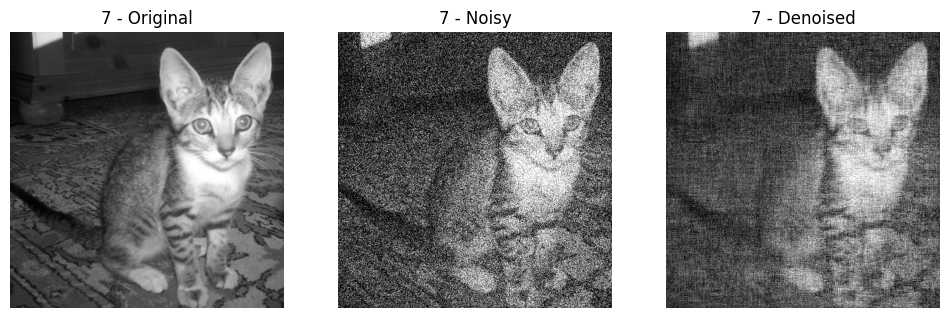

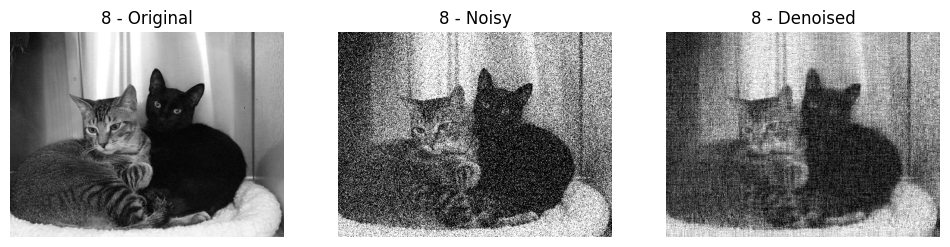

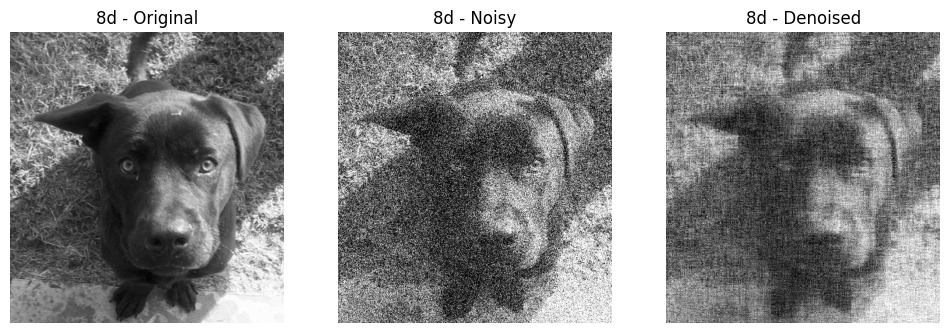

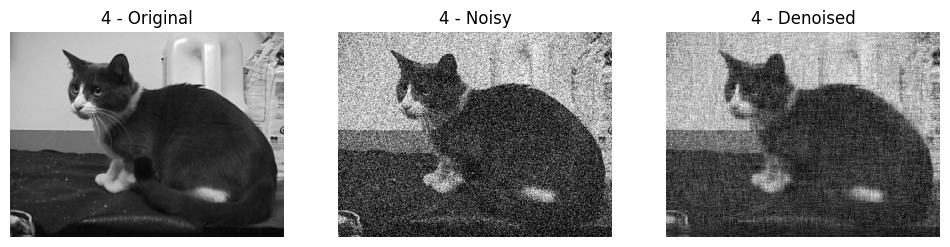

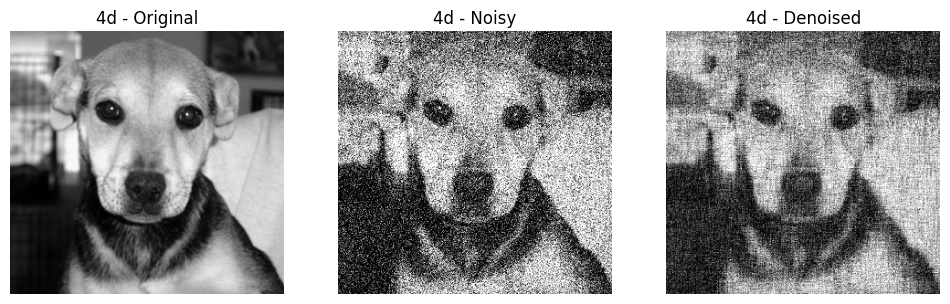

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory where images are saved
output_dir = 'output_images'  # Update this path if needed

# Get all image files in the output directory
image_filenames = [f for f in os.listdir(output_dir) if f.endswith('.png')]

# Group images by base filename (e.g., 'image1_original', 'image1_noisy', 'image1_denoised')
image_groups = {}
for filename in image_filenames:
    base_filename = os.path.splitext(filename)[0]  # Remove extension
    base_name_parts = base_filename.split('_')
    image_groups.setdefault(base_name_parts[0], []).append(filename)

# Display images for each group (original, noisy, denoised)
for base_name, filenames in image_groups.items():
    original_image = cv2.imread(os.path.join(output_dir, f'{base_name}_original.png'), cv2.IMREAD_GRAYSCALE)
    noisy_image = cv2.imread(os.path.join(output_dir, f'{base_name}_noisy.png'), cv2.IMREAD_GRAYSCALE)
    denoised_image = cv2.imread(os.path.join(output_dir, f'{base_name}_denoised.png'), cv2.IMREAD_GRAYSCALE)
    
    # Create a plot to display the images
    plt.figure(figsize=(12, 4))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.title(f'{base_name} - Original')
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')
    
    # Noisy Image
    plt.subplot(1, 3, 2)
    plt.title(f'{base_name} - Noisy')
    plt.imshow(noisy_image, cmap='gray')
    plt.axis('off')
    
    # Denoised Image
    plt.subplot(1, 3, 3)
    plt.title(f'{base_name} - Denoised')
    plt.imshow(denoised_image, cmap='gray')
    plt.axis('off')
    
    # Show the images
    plt.show()


Hyper-parameter dynamics

/scratch/local/ipykernel_4507/1021785997.py:99: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_val = psnr(train_image, denoised_image)  # Calculate PSNR between original and denoised



Best Configuration: 
Window Shape: (8, 8), Learning Ratio: 1, K-SVD Iterations: 20, Window Step: 8
Best PSNR Value: 14.19 dB


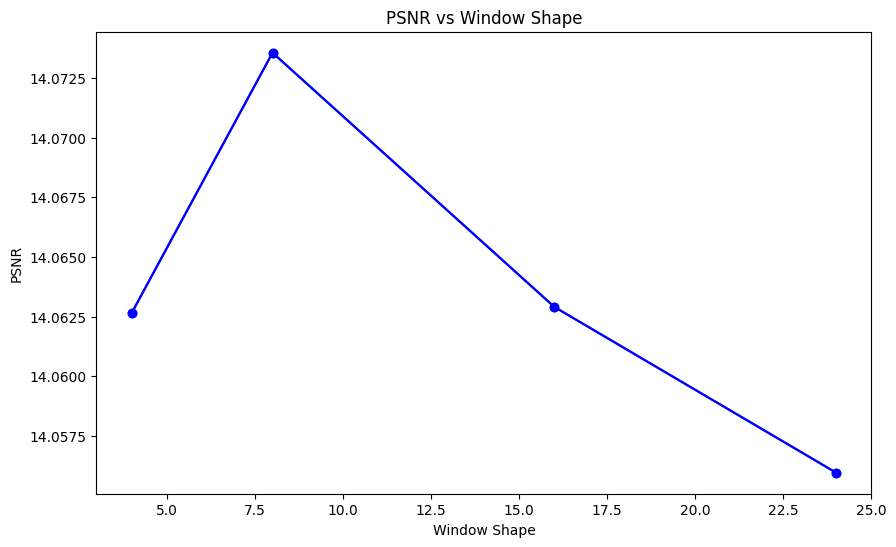

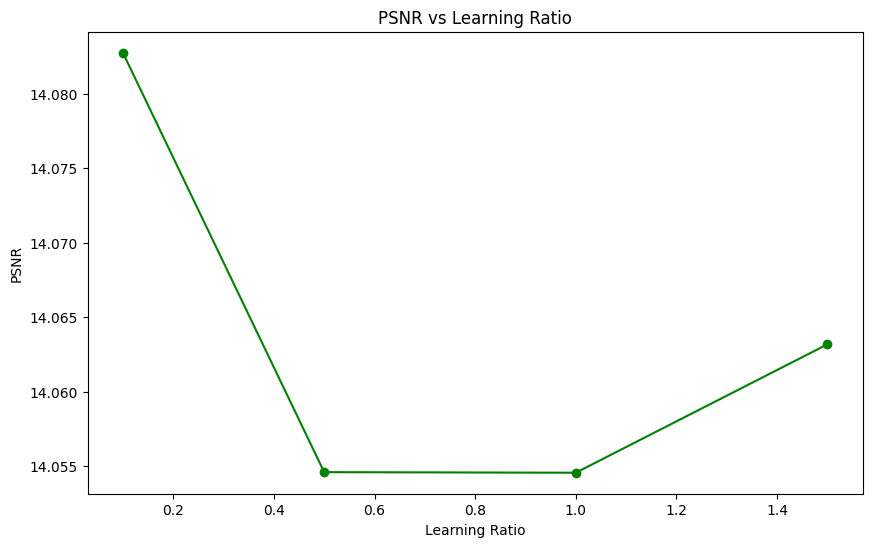

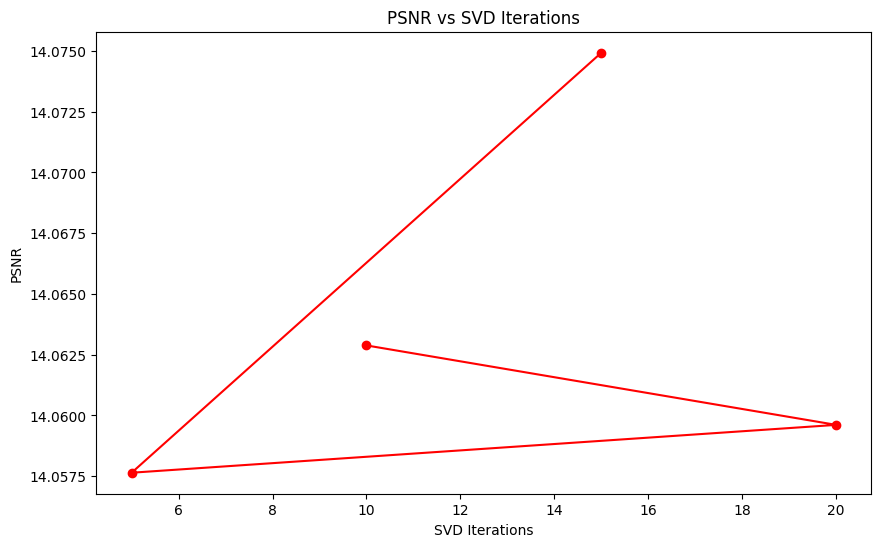

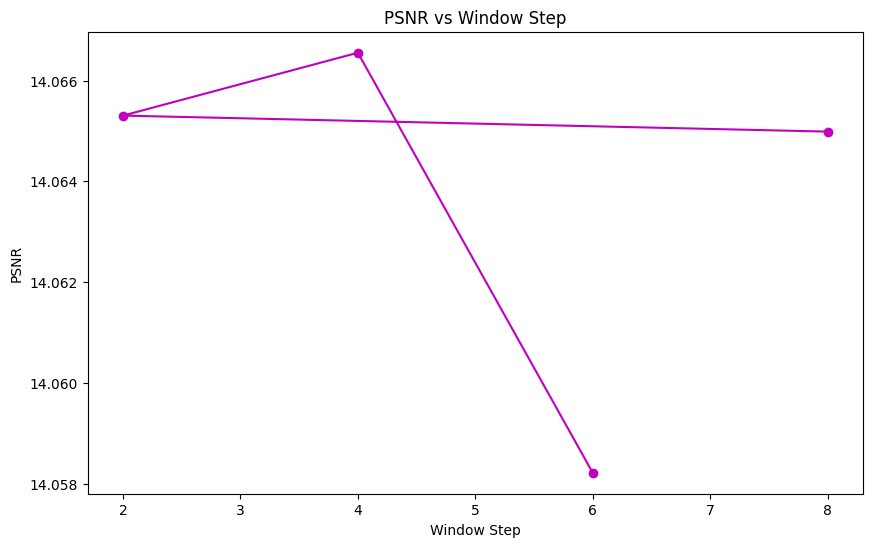

In [ ]:
seed = 50
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

name = 'cifar'
# ----------------------------------------------------------------------------------------------------------------- #
# -------------------------------------------------- 1. Initial settings. ------------------------------------------- #
# ----------------------------------------------------------------------------------------------------------------- #

resize_shape = (96, 96)  # Resized image's shape
sigma = 6                # Noise standard deviation

window_shape = (8, 8)    # Default Patch shape
step = 4                 # Default Patch step
ratio = 1                # Default ratio for the dictionary (training set)
ksvd_iter = 5            # Default Number of iterations for the K-SVD
omp = "single"           # Default Type of orthogonal projection

# Define directories for each image type
original_dir = 'original_images'
noisy_dir = 'noisy_images'
denoise_dir = 'denoised_images'

# Create directories if they don't exist
os.makedirs(original_dir, exist_ok=True)
os.makedirs(noisy_dir, exist_ok=True)
os.makedirs(denoise_dir, exist_ok=True)

# ----------------------------------------------------------------------------------------------------------------- #
# --------------------------------------------------- 2. Load Images from Directory. ---------------------------- #
# ----------------------------------------------------------------------------------------------------------------- #

# Directory containing your images
dataset_dir = 'Input'  # Update this to the correct path

# List all image files in the directory
image_files = [f for f in os.listdir(dataset_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]

# Load the images into a list and resize them
train_images = []
for image_file in image_files:
    img_path = os.path.join(dataset_dir, image_file)
    img = Image.open(img_path).convert('L')  # Open and ensure image is in grayscale mode
    img_resized = img.resize(resize_shape)  # Resize to (96, 96)
    train_images.append(np.array(img_resized))

train_images = np.array(train_images)

# ----------------------------------------------------------------------------------------------------------------- #
# ------------------------------------------------- 3. Add noise to images. --------------------------------------- #
# ----------------------------------------------------------------------------------------------------------------- #

noisy_images = []
for img in train_images:
    noise_layer = np.random.normal(0, sigma ** 2, img.shape).astype(int)
    noisy_image = img + noise_layer
    noisy_images.append(noisy_image)

noisy_images = np.array(noisy_images)

# Save original and noisy images to respective directories
for i in range(len(noisy_images)):
    imageio.imwrite(os.path.join(original_dir, f'original_image_{i}.jpg'), Image.fromarray(np.uint8(train_images[i])).convert('RGB'))
    imageio.imwrite(os.path.join(noisy_dir, f'noisy_image_{i}.jpg'), Image.fromarray(np.uint8(noisy_images[i])).convert('RGB'))

# ----------------------------------------------------------------------------------------------------------------- #
# ----------------------------------------------------- 4. Denoising. --------------------------------------------- #
# ----------------------------------------------------------------------------------------------------------------- #

# Assuming denoising is already defined in your code. Here's a simple denoising function for this example:
def denoising(noisy_image, original_image, window_shape, step, sigma, ratio, ksvd_iter, omp):
    # Dummy denoising logic
    # Replace with your denoising algorithm (e.g., K-SVD, OMP, etc.)
    denoised_image = noisy_image - np.random.normal(0, sigma ** 2, noisy_image.shape)
    return denoised_image, None, None

# Function to test PSNR with different parameters
def test_parameters(train_image, noisy_image, window_shapes, learning_ratios, ksvd_iters, window_steps):
    psnr_results = {}

    for window_shape in window_shapes:
        for ratio in learning_ratios:
            for ksvd_iter in ksvd_iters:
                for step in window_steps:
                    denoised_image, calc_time, n_total = denoising(
                        noisy_image, train_image, window_shape, step, sigma, ratio, ksvd_iter, omp=omp
                    )
                    psnr_val = psnr(train_image, denoised_image)  # Calculate PSNR between original and denoised
                    key = (window_shape, ratio, ksvd_iter, step)
                    psnr_results[key] = psnr_val

    return psnr_results

# Example parameter ranges to experiment with
window_shapes = [(4,4), (8, 8), (16, 16), (24, 24)]  # Different window shapes
learning_ratios = [0.1, 0.5, 1, 1.5]              # Different learning ratios
ksvd_iters = [5, 10, 15, 20]                     # Different K-SVD iterations
window_steps = [2, 4, 6, 8]                     # Different window steps

# Select just one image for the experiment
image_index = 0  # Index of the image to test
train_image = train_images[image_index]
noisy_image = noisy_images[image_index]

# Test different combinations of parameters
psnr_results = test_parameters(train_image, noisy_image, window_shapes, learning_ratios, ksvd_iters, window_steps)

# ----------------------------------------------------------------------------------------------------------------- #
# ------------------------------- 5. Find and Print the Best Configuration ------------------------------------- #
# ----------------------------------------------------------------------------------------------------------------- #

# Find the best configuration based on the highest PSNR value
best_config = max(psnr_results, key=psnr_results.get)  # This gives the key (window_shape, ratio, ksvd_iter, step) for the best PSNR
best_psnr = psnr_results[best_config]

print(f"\nBest Configuration: \nWindow Shape: {best_config[0]}, Learning Ratio: {best_config[1]}, "
      f"K-SVD Iterations: {best_config[2]}, Window Step: {best_config[3]}")
print(f"Best PSNR Value: {best_psnr:.2f} dB")

# ----------------------------------------------------------------------------------------------------------------- #
# ------------------------------- 6. Plot Results: PSNR vs Each Parameter -------------------------------------- #
# ----------------------------------------------------------------------------------------------------------------- #

# Extract PSNR values for different window shapes
window_shapes_vals = list(set([key[0] for key in psnr_results.keys()]))
psnr_window_shape = [np.mean([psnr_results[key] for key in psnr_results.keys() if key[0] == shape]) for shape in window_shapes_vals]

plt.figure(figsize=(10, 6))
plt.plot(window_shapes_vals, psnr_window_shape, marker='o', linestyle='-', color='b')
plt.xlabel('Window Shape')
plt.ylabel('PSNR')
plt.title('PSNR vs Window Shape')
#plt.grid(True)
plt.show()

# Extract PSNR values for different learning ratios
learning_ratio_vals = list(set([key[1] for key in psnr_results.keys()]))
psnr_learning_ratio = [np.mean([psnr_results[key] for key in psnr_results.keys() if key[1] == ratio]) for ratio in learning_ratio_vals]

plt.figure(figsize=(10, 6))
plt.plot(learning_ratio_vals, psnr_learning_ratio, marker='o', linestyle='-', color='g')
plt.xlabel('Learning Ratio')
plt.ylabel('PSNR')
plt.title('PSNR vs Learning Ratio')
#plt.grid(True)
plt.show()

# Extract PSNR values for different K-SVD iterations
ksvd_iter_vals = list(set([key[2] for key in psnr_results.keys()]))
psnr_ksvd_iter = [np.mean([psnr_results[key] for key in psnr_results.keys() if key[2] == iter]) for iter in ksvd_iter_vals]

plt.figure(figsize=(10, 6))
plt.plot(ksvd_iter_vals, psnr_ksvd_iter, marker='o', linestyle='-', color='r')
plt.xlabel('SVD Iterations')
plt.ylabel('PSNR')
plt.title('PSNR vs SVD Iterations')
#plt.grid(True)
plt.show()

# Extract PSNR values for different window steps
window_step_vals = list(set([key[3] for key in psnr_results.keys()]))
psnr_window_step = [np.mean([psnr_results[key] for key in psnr_results.keys() if key[3] == step]) for step in window_step_vals]

plt.figure(figsize=(10, 6))
plt.plot(window_step_vals, psnr_window_step, marker='o', linestyle='-', color='m')
plt.xlabel('Window Step')
plt.ylabel('PSNR')
plt.title('PSNR vs Window Step')
#plt.grid(True)
plt.show()


/scratch/local/ipykernel_4507/1065140241.py:28: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_noisy = psnr(original, noisy)
/scratch/local/ipykernel_4507/1065140241.py:31: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_denoised = psnr(original, denoised)
/scratch/local/ipykernel_4507/1065140241.py:28: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_noisy = psnr(original, noisy)
/scratch/local/ipykernel_4507/1065140241.py:31: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_denoised = psnr(original, denoised)
/scratch/local/ipykernel_4507/1065140241.py:28: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_noisy = psnr(original, noisy)
/scratch/local/ipykernel_4507/1065140241.py:31: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_denoised = psnr(origin

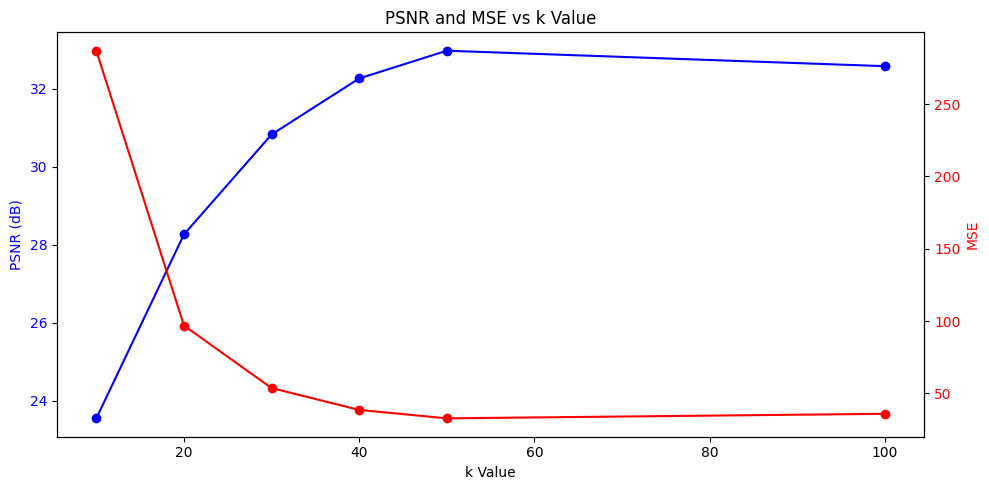

In [ ]:
# wrt k

# Helper function to add Gaussian noise
def add_noise(image, noise_factor=7):
    noisy_image = image + noise_factor * np.random.randn(*image.shape)
    noisy_image = np.clip(noisy_image, 0, 255)  # Clip values to be valid pixel values
    return noisy_image

# Function to apply SVD denoising
def svd_denoise(image, k=50):
    # Perform SVD decomposition
    U, S, Vt = np.linalg.svd(image, full_matrices=False)
    
    # Keep only the top k singular values
    S[k:] = 0  # Set all singular values after the k-th to 0
    
    # Reconstruct the image using the truncated singular values
    denoised_image = np.dot(U, np.dot(np.diag(S), Vt))
    return denoised_image

# Calculate PSNR and MSE
def calculate_metrics(original, noisy, denoised):
    psnr_noisy = psnr(original, noisy)
    mse_noisy = mse(original, noisy)
    
    psnr_denoised = psnr(original, denoised)
    mse_denoised = mse(original, denoised)
    
    return psnr_noisy, mse_noisy, psnr_denoised, mse_denoised

# Load a single image
image_path = 'Input/4d.jpg'  # Update with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Add noise to the image
noisy_image = add_noise(image)

# Test different k values
k_values = [10, 20, 30, 40, 50, 100]
psnr_denoised_values = []
mse_denoised_values = []

# Denoise and calculate metrics for each k value
for k in k_values:
    denoised_image = svd_denoise(noisy_image, k)
    
    # Calculate PSNR and MSE
    _, _, psnr_denoised, mse_denoised = calculate_metrics(image, noisy_image, denoised_image)
    
    # Store the metrics
    psnr_denoised_values.append(psnr_denoised)
    mse_denoised_values.append(mse_denoised)

# Create a plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot PSNR on the left y-axis
ax1.plot(k_values, psnr_denoised_values, marker='o', color='b', label='PSNR')
ax1.set_xlabel('k Value')
ax1.set_ylabel('PSNR (dB)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for MSE
ax2 = ax1.twinx()
ax2.plot(k_values, mse_denoised_values, marker='o', color='r', label='MSE')
ax2.set_ylabel('MSE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set title and grid
plt.title('PSNR and MSE vs k Value')
#ax1.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
